In [1]:
import os
import bokeh
from bokeh.plotting import show
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phenograph
import pacmap
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import flowkit as fk

bokeh.io.output_notebook()
%matplotlib inline

Loading BokehJS ...

### Load Samples & FlowJo 10 workspace

In [2]:
base_dir = "data/8_color_data_set/"
sample_path = os.path.join(base_dir, "fcs_files")
wsp_path = os.path.join(base_dir, "8_color_ICS.wsp")

seed = 123

In [3]:
session = fk.Session(sample_path)
session.import_flowjo_workspace(wsp_path)

In [4]:
sample_groups = session.get_sample_groups()
sample_groups

['default', 'All Samples', 'DEN']

In [5]:
sample_group = sample_groups[-1]

In [6]:
print(session.get_gate_hierarchy(sample_group, output='ascii'))

root
╰── Time
    ╰── Singlets
        ╰── aAmine-
            ╰── CD3+
                ├── CD4+
                │   ├── CD107a+
                │   ├── IFNg+
                │   ├── IL2+
                │   ╰── TNFa+
                ╰── CD8+
                    ├── CD107a+
                    ├── IFNg+
                    ├── IL2+
                    ╰── TNFa+


In [7]:
sample_ids = session.get_sample_ids()
sample_ids

['101_DEN084Y5_15_E03_009_clean.fcs',
 '101_DEN084Y5_15_E01_008_clean.fcs',
 '101_DEN084Y5_15_E05_010_clean.fcs']

### Run analyze_samples & retrieve gated events as DataFrames

In [8]:
session.analyze_samples(sample_group)

#### Processing gates for 3 samples (multiprocessing is enabled - 3 cpus) ####


In [9]:
dfs = session.get_wsp_gated_events(sample_group, gate_name="Singlets")

In [10]:
dfs[0].head()

,sample_group,sample_id,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,TNFa FITC FLR-A,CD8 PerCP-Cy55 FLR-A,IL2 BV421 FLR-A,Aqua Amine FLR-A,IFNg APC FLR-A,CD3 APC-H7 FLR-A,CD107a PE FLR-A,CD4 PE-Cy7 FLR-A,Time
6,DEN,101_DEN084Y5_15_E01_008_clean.fcs,0.632765,0.519402,0.304564,0.116014,0.111382,0.260397,0.253992,0.225618,0.253962,0.250438,0.235338,0.419341,0.276203,0.548099,0.036353
7,DEN,101_DEN084Y5_15_E01_008_clean.fcs,0.428379,0.338997,0.315916,0.205931,0.192833,0.266981,0.241998,0.240605,0.328635,0.248555,0.241893,0.240895,0.283410,0.256122,0.036381
8,DEN,101_DEN084Y5_15_E01_008_clean.fcs,0.600745,0.502071,0.299133,0.349897,0.309628,0.282515,0.556043,0.324994,0.397557,0.305441,0.272172,0.244708,0.701451,0.301256,0.036396
9,DEN,101_DEN084Y5_15_E01_008_clean.fcs,0.415333,0.329010,0.315593,0.200316,0.182648,0.274184,0.254298,0.329108,0.320049,0.257477,0.271226,0.500196,0.319537,0.594672,0.036452
10,DEN,101_DEN084Y5_15_E01_008_clean.fcs,0.427080,0.328156,0.325364,0.296132,0.262680,0.281837,0.260209,0.296330,0.316296,0.262380,0.266253,0.451234,0.284111,0.618065,0.036467


In [11]:
k = 10_000
X = pd.concat([df.iloc[:, 2:-1].sample(k) for df in dfs])

In [12]:
X.head()

,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,TNFa FITC FLR-A,CD8 PerCP-Cy55 FLR-A,IL2 BV421 FLR-A,Aqua Amine FLR-A,IFNg APC FLR-A,CD3 APC-H7 FLR-A,CD107a PE FLR-A,CD4 PE-Cy7 FLR-A
227806,0.531685,0.408527,0.325367,0.217740,0.200626,0.271325,0.264019,0.320289,0.362921,0.253962,0.247002,0.235636,0.287146,0.237291
10286,0.620557,0.516186,0.300549,0.145231,0.136169,0.266637,0.254091,0.264570,0.244074,0.253258,0.245713,0.377155,0.258391,0.474945
123314,0.697913,0.589802,0.295825,0.587256,0.485676,0.302288,0.417091,0.374328,0.454928,0.315247,0.274370,0.292113,0.556776,0.288575
127132,0.463584,0.383781,0.301984,0.196639,0.180763,0.271957,0.247272,0.251398,0.306950,0.242894,0.235805,0.476216,0.283262,0.572711
117791,0.533147,0.415974,0.320421,0.174803,0.165668,0.263784,0.244781,0.571990,0.292502,0.253258,0.245398,0.489266,0.298063,0.304113


### Perform Louvain & Leiden clustering

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
communities_louvain, graph_louvain, Q_louvain = phenograph.cluster(
    X_scaled, 
    clustering_algo='louvain', 
    seed=seed
)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 9.177159547805786 seconds
Jaccard graph constructed in 2.0372724533081055 seconds
Wrote graph to binary file in 0.5435771942138672 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.854404
After 8 runs, maximum modularity is Q = 0.855693
Louvain completed 28 runs in 39.60832643508911 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 51.651323556900024 seconds


In [15]:
communities_leiden, graph_leiden, Q_leiden = phenograph.cluster(
    X_scaled, 
    clustering_algo='leiden',
    seed=seed
)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 8.166494607925415 seconds
Jaccard graph constructed in 1.9222848415374756 seconds
Running Leiden optimization
Leiden completed in 3.3636934757232666 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 14.683838844299316 seconds


In [16]:
titles = ['Leiden', 'Louvain']
communities = [communities_leiden, communities_louvain]

In [17]:
leiden_means = [
    X_scaled[communities_leiden==i, :].mean(axis=0)
    for i in np.unique(communities_leiden)
]
leiden_clusters = pd.DataFrame(
    leiden_means, 
    columns = X.columns, 
    index=np.unique(communities_leiden)
)
leiden_clusters.index.name = 'Cluster'

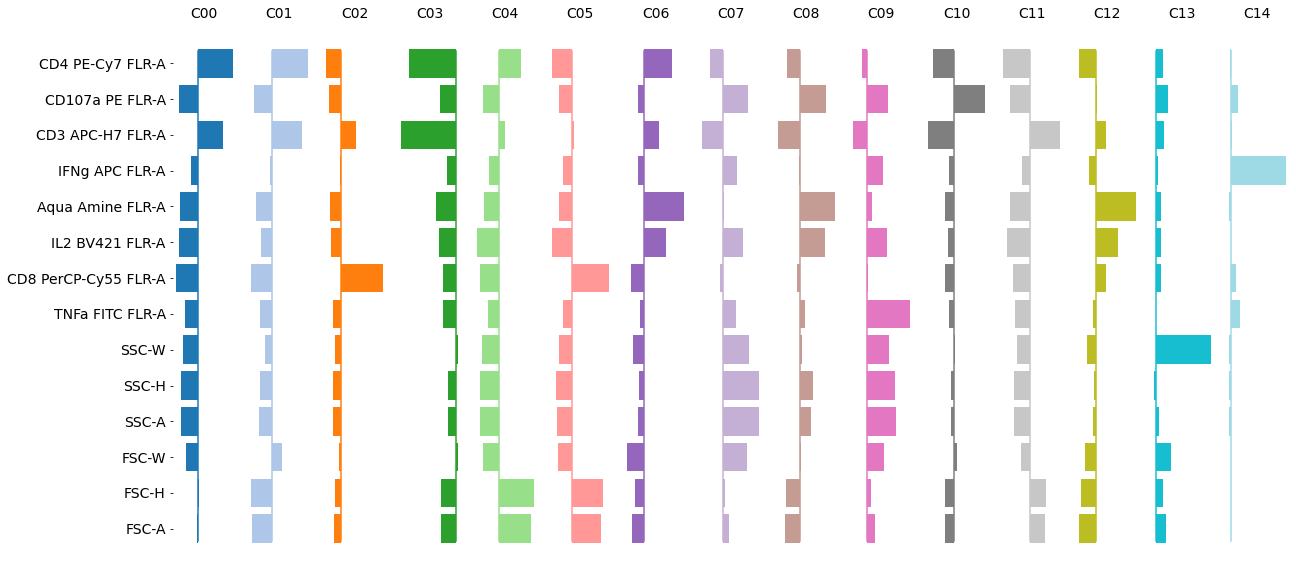

In [18]:
tab20 = plt.cm.get_cmap('tab20')
n, p = leiden_clusters.shape

fig, axes = plt.subplots(1, n, figsize=(20, 10))

for i, ax in enumerate(axes.ravel()):
    ax.barh(range(p), leiden_clusters.iloc[i,:], color=tab20(int(i*(20+1)/n)))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    ax.set_title(f'C{i:02d}', fontsize=14)
    ax.axvline(0, c=tab20(int(i*(20+1)/n)), ymin=0.05, ymax=0.95)
    
    if i == 0:
        ax.set_yticks(range(p))
        ax.set_yticklabels(leiden_clusters.columns,fontsize=14)

### Apply dimension reduction using PaCMAP

In [19]:
embedder = pacmap.PaCMAP()

In [20]:
X2 = embedder.fit_transform(X_scaled)

In [21]:
min_max_scaler = MinMaxScaler()
X2 = min_max_scaler.fit_transform(X2)

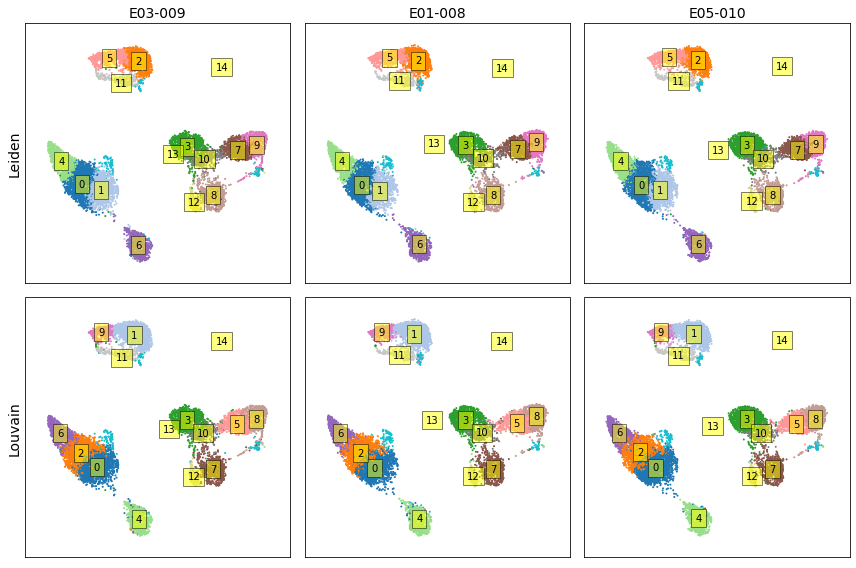

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, (community, title) in enumerate(zip(communities, titles)):
    for j in range(3):
        z = community[(j*k):(j+1)*k]
        x = X2[(j*k):(j+1)*k, 0]
        y = X2[(j*k):(j+1)*k, 1]
        
        ax = axes[i, j]
        ax.scatter(x, y, s=1, c=z, cmap='tab20')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim([-0.1,1.1])
        ax.set_ylim([-0.1,1.1])
        if j==0:
            ax.set_ylabel(title, fontsize=14)
        if i==0:
            ax.set_title('-'.join(sample_ids[j].split('_')[3:5]), fontsize=14)
            
        for idx in np.unique(z):
            x_, y_ = x[z==idx], y[z==idx]
            x_c, y_c = np.mean(x_), np.mean(y_)
            
            ax.text(
                x_c, 
                y_c, 
                str(idx), 
                va='center', 
                ha='center', 
                bbox=dict(fc='yellow', alpha=0.5)
            )
            
plt.tight_layout()